In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unifying import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(1)
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.current_device())

cuda
True
1.6.0+cu101
0


In [3]:
hydraulic_data = get_variable_profile_set(Normalized=True) 

In [4]:
normal_set=[]
abnormal_set=[]
for instance_set in hydraulic_data:
    variables, profiles = instance_set
    if profiles[4]==0:
        normal_set.append(variables)
    elif profiles[4]==1:
        abnormal_set.append(variables)
    else:
        print('data error')
        break

In [5]:
print(len(normal_set))
print(len(abnormal_set))

1449
756


# Model Definition

In [6]:
class Encoder(nn.Module):
    def __init__(self, n_features, emb_dim):
        super(Encoder, self).__init__()
        
        self.Linear1 = nn.Linear(n_features, 10)
        self.Linear2 = nn.Linear(10, emb_dim)
        
    def forward(self, x):
        x = self.Linear1(x)
        x = F.sigmoid(x)
        x = self.Linear2(x)
        return F.sigmoid(x)
    
class Decoder(nn.Module):
    def __init__(self, n_features, emb_dim):
        super(Decoder, self).__init__()
        
        self.Linear1 = nn.Linear(emb_dim, 8)
        self.Linear2 = nn.Linear(8, n_features)
        
    def forward(self, x):
        x = self.Linear1(x)
        x = F.sigmoid(x)
        x = self.Linear2(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, n_features, emb_dim=5):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(n_features, emb_dim).to(device)
        self.decoder = Decoder(n_features, emb_dim).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [7]:
model = Autoencoder(17,emb_dim=3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train on Normal data

## Data Reshaping

In [8]:
Hydraulic_train = [torch.tensor(x).float() for x in normal_set[:1000]]
Hydraulic_test_normal = [torch.tensor(x).float() for x in normal_set[1000:]]
Hydraulic_test_abnormal = [torch.tensor(x).float() for x in abnormal_set]

len(Hydraulic_train)

1000

In [9]:
Hydraulic_train[0].shape

torch.Size([17, 6000])

In [13]:
Hydraulic_train_devided=Hydraulic_train[0]
for i in Hydraulic_train[1:]:
    Hydraulic_train_devided=torch.cat((Hydraulic_train_devided, i), dim=1)
    
    

In [14]:
Hydraulic_train_devided.shape

torch.Size([17, 6000000])

In [15]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, timeseries, transform=None):#timeseries = variables * time
        self.transform = transform
        self.data_num = timeseries.shape[1]
        self.data = []
        self.label = 0
        for i in range(timeseries.shape[1]):
            self.data.append(timeseries[:, i])
            
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label
        
        return out_data, out_label

In [23]:
train_data = MyDataset(Hydraulic_train_devided)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10000, shuffle=False)

## Train Function

In [24]:
def train(model, train_loader, criterion, optimizer, n_epochs=100):
    losses = []
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0      

        for data in train_loader:
            optimizer.zero_grad()
            z, _ = data
            z_cuda = z.to(device)
            preds = model(z_cuda)
            loss = criterion(preds, z_cuda)
            loss.backward()
            optimizer.step()
            running_loss += loss.data
          
        
        ave_loss = running_loss / len(train_data)
        losses.append(ave_loss)
        if epoch%3==0:
            print(f'epoch:{epoch:3} loss: {ave_loss:10.8f}')

    plt.plot(losses)
    return losses

epoch:  0 loss: 0.00003640
epoch:  3 loss: 0.00003591
epoch:  6 loss: 0.00002305
epoch:  9 loss: 0.00001478
epoch: 12 loss: 0.00001319
epoch: 15 loss: 0.00001255
epoch: 18 loss: 0.00001212
epoch: 21 loss: 0.00001175
epoch: 24 loss: 0.00001142
epoch: 27 loss: 0.00001111
epoch: 30 loss: 0.00001084
epoch: 33 loss: 0.00001061
epoch: 36 loss: 0.00001042
epoch: 39 loss: 0.00001026
epoch: 42 loss: 0.00001012
epoch: 45 loss: 0.00000998
epoch: 48 loss: 0.00000985


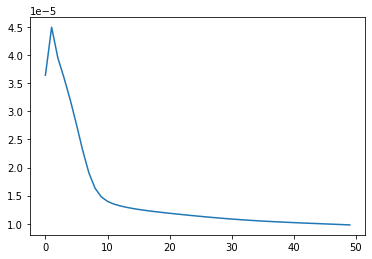

In [25]:
with torch.autograd.set_detect_anomaly(True):
    losses = train(model, train_loader, loss_function, optimizer, n_epochs=50)

In [26]:
model_path = 'ae_model8_3_withloader.pth'
torch.save(model.to('cpu').state_dict(), model_path)

# Test

In [57]:
def test(model, criterion, test_data):
    model.to(device)
    model.eval()
    reconstruct_error = []
    reconstruct = []

    with torch.no_grad():
        for i in range(len(test_data)):#1000*17*6000
            sub_data = test_data[i].to(device)#17*6000
            re_sub=[]
            r_sub=[]
            for j in range(sub_data.shape[1]):
                z = sub_data[:,j].to(device)
                pred = model(z)
                loss = criterion(pred, z)
                re_sub.append(loss)
                r_sub.append(pred.cpu().numpy())
            reconstruct_error.append(re_sub)
            reconstruct.append(r_sub)
            
    plt.show()
    return np.array(reconstruct_error), np.array(reconstruct)


In [58]:
reconstruct_error_train, reconstruct_train = test(model, loss_function, Hydraulic_train)



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [ ]:
reconstruct_error_test, reconstruct_test = test(model, loss_function, Hydraulic_test_abnormal)

In [ ]:
reconstruct_error_test_n, reconstruct_test_n = test(model, loss_function, Hydraulic_test_normal)

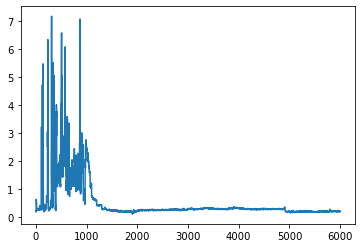

In [43]:
plt.plot(reconstruct_error_train[200])

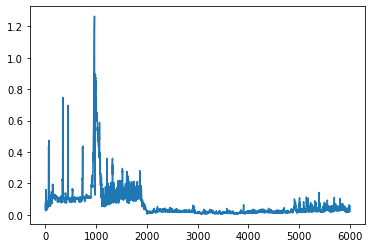

In [47]:
plt.plot(reconstruct_error_test_n[200])

In [61]:

re_ab=np.sum(reconstruct_error_test, axis=1)
re_n=np.sum(reconstruct_error_test_n, axis=1)

In [65]:
re_ab_ = np.array([x.cpu().detach().numpy() for x in re_ab])
re_n_ = np.array([x.cpu().detach().numpy() for x in re_n])

(array([458.,  83., 142.,  56.,   6.,   7.,   1.,   0.,   2.,   1.]),
 array([ 124.87518,  868.96405, 1613.0529 , 2357.1418 , 3101.2305 ,
        3845.3193 , 4589.408  , 5333.497  , 6077.586  , 6821.675  ,
        7565.7637 ], dtype=float32),
 <BarContainer object of 10 artists>)

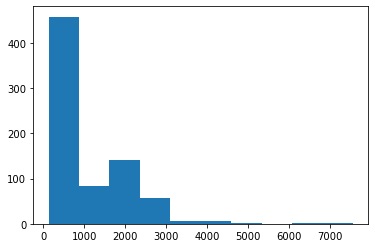

In [67]:
plt.hist(re_ab_)

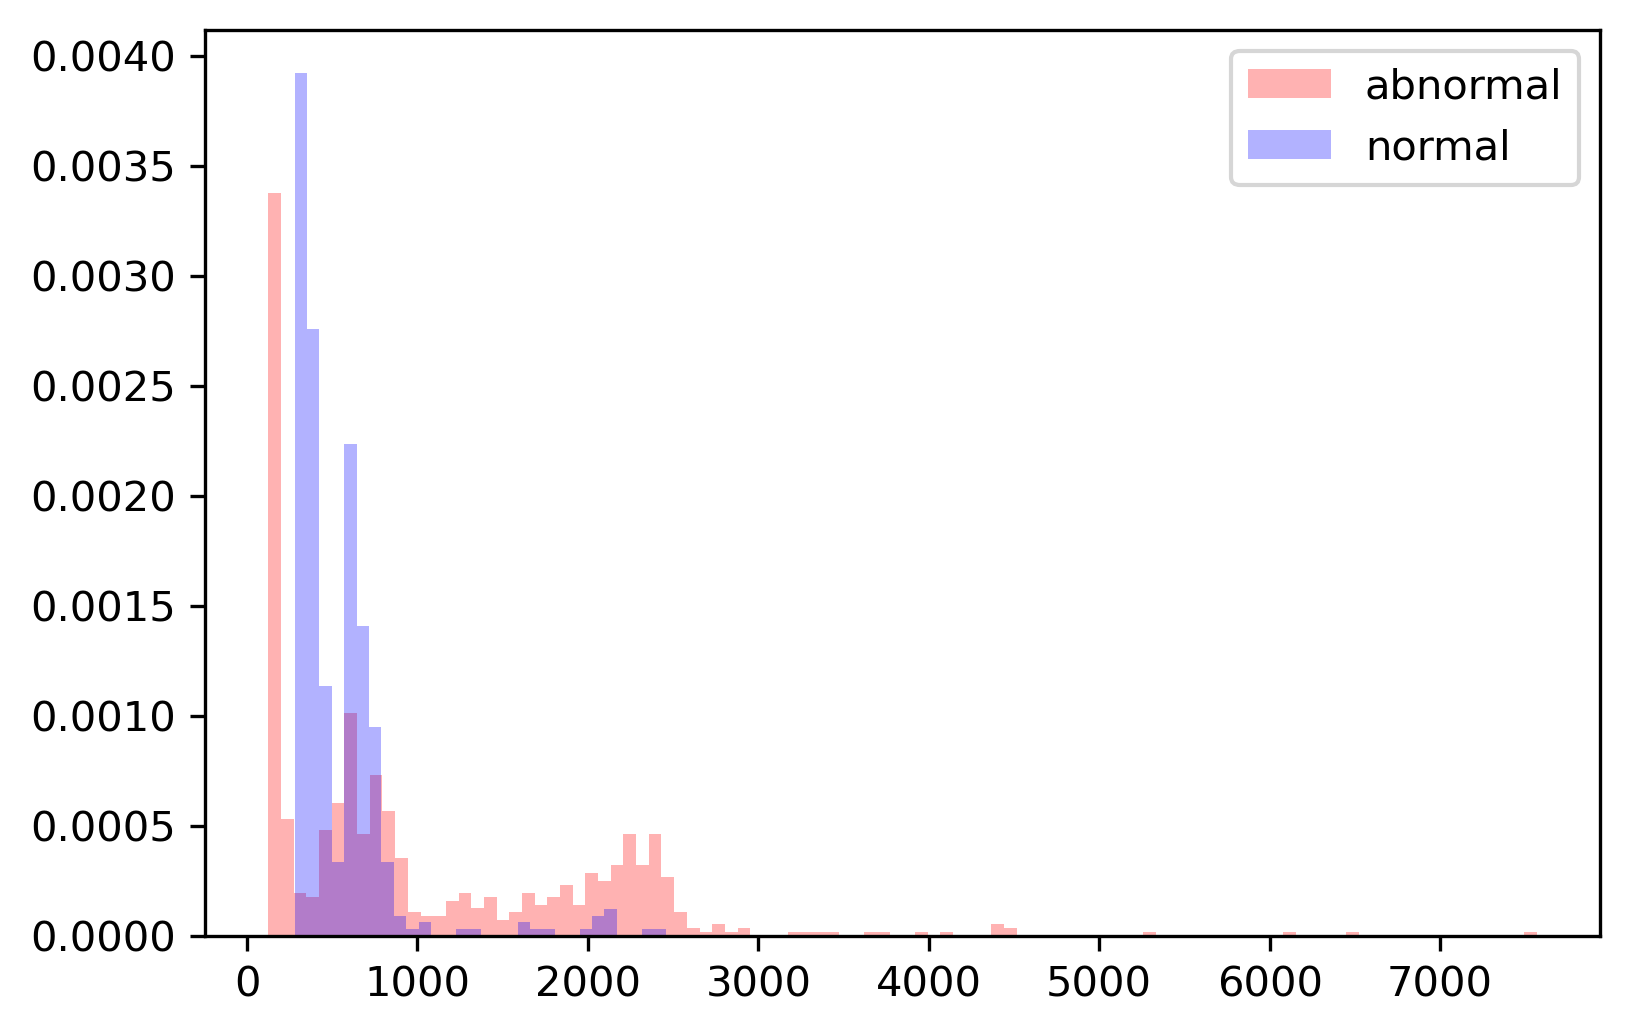

In [93]:
plt.figure(dpi=300)
plt.hist(re_ab_, bins=100, alpha=0.3, histtype='stepfilled', density=True, color='r' , label='abnormal')
plt.hist(re_n_, bins=30, alpha=0.3, histtype='stepfilled', density=True, color='b', label='normal')
plt.legend()
plt.show()

# Figures

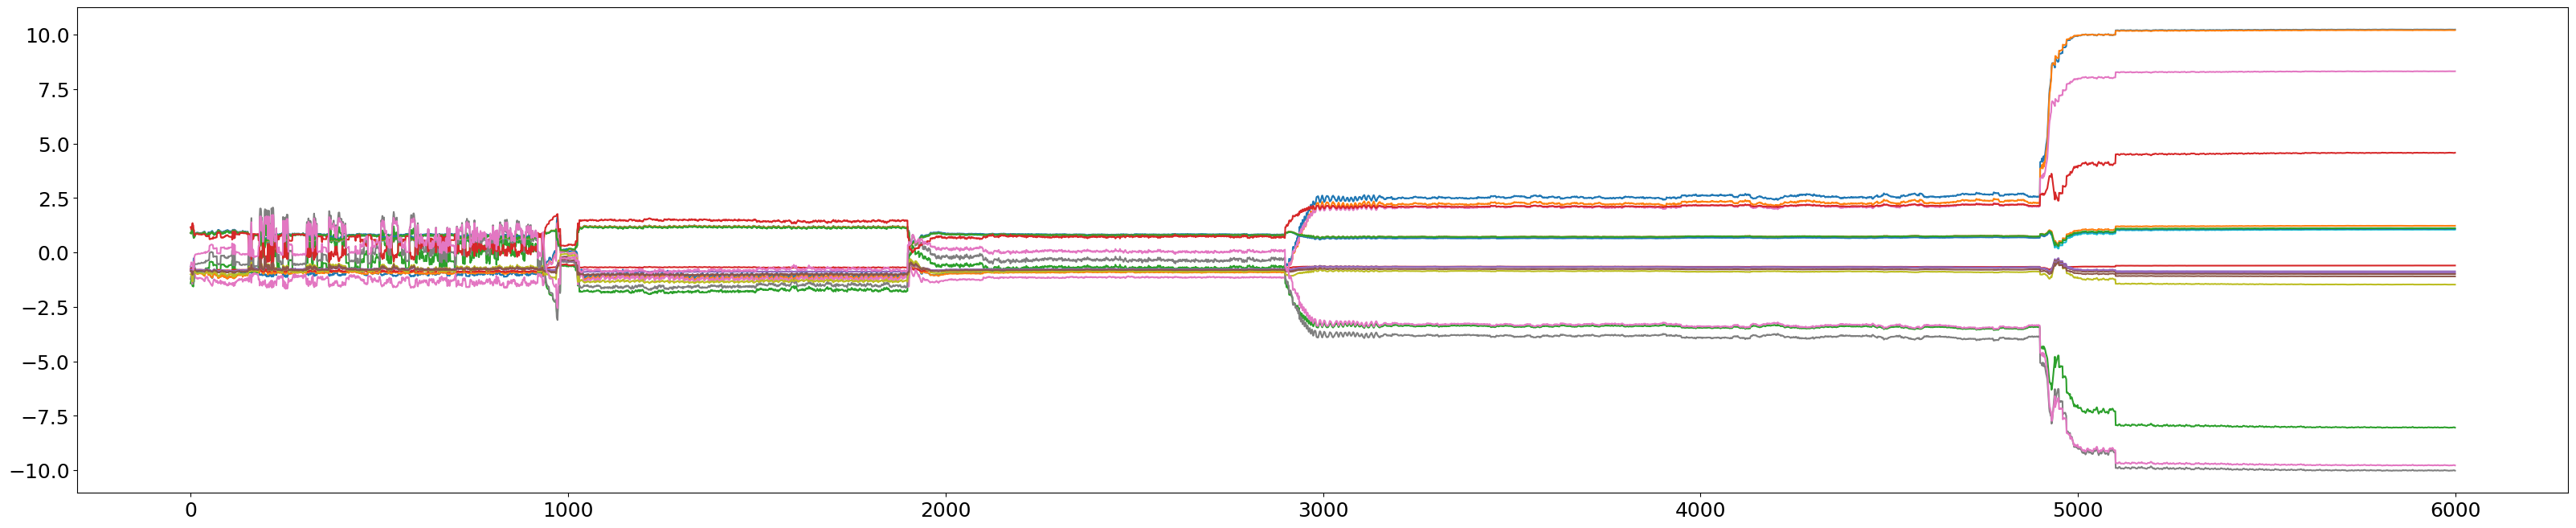

In [137]:
fig = plt.figure(figsize=(40,8),dpi=100)
plt.plot(reconstruct_train[0])

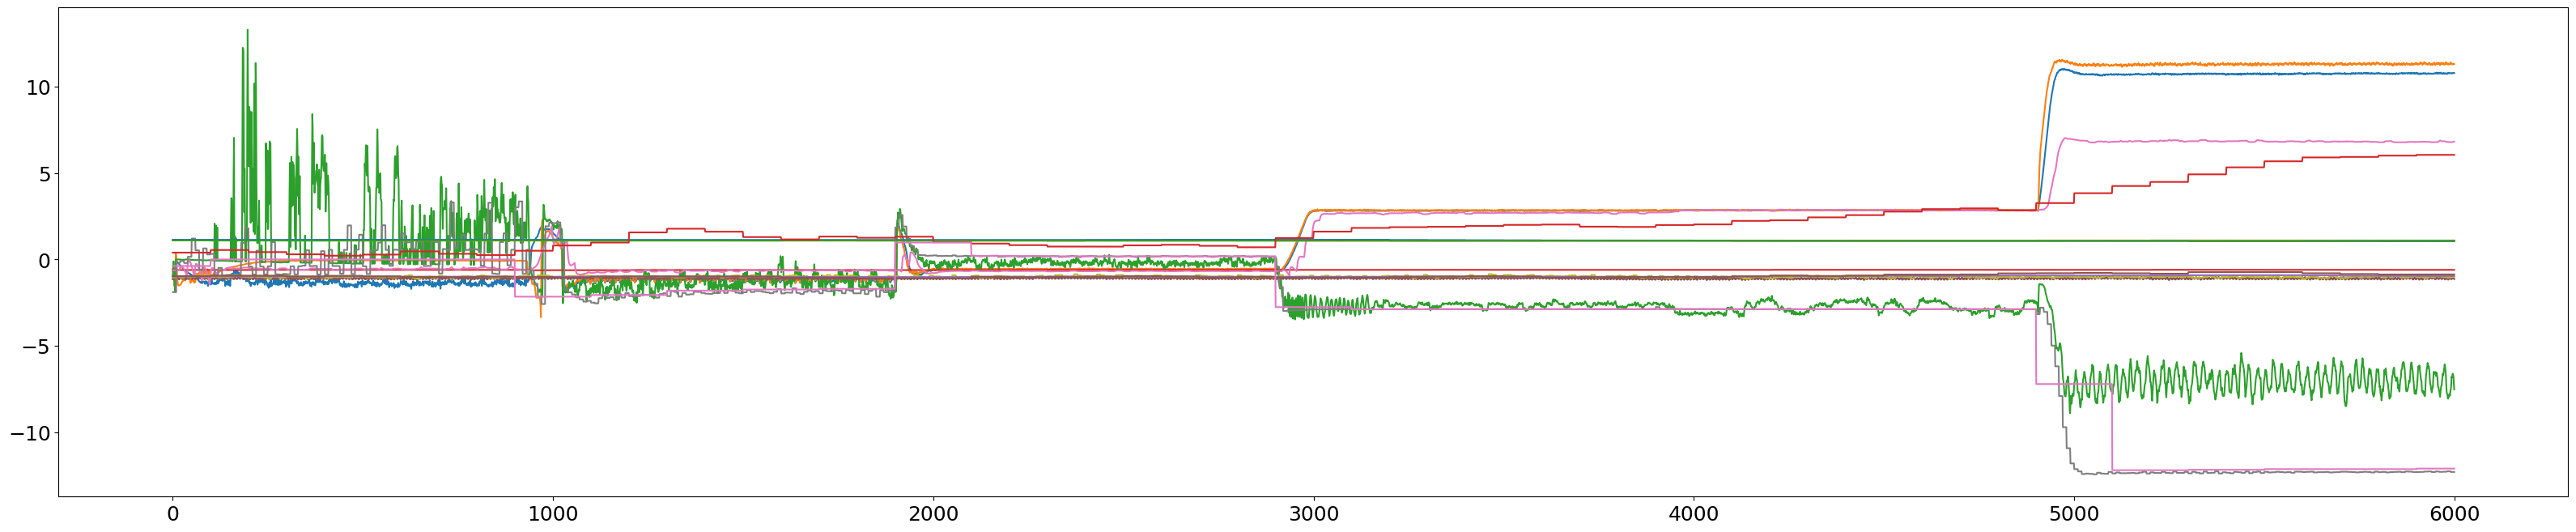

In [138]:
fig = plt.figure(figsize=(40,8),dpi=100)
plt.plot(Hydraulic_train[0].T)

In [89]:
reconstruct_test[0].shape

(6000, 17)

In [111]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.hstack([np.ones(len(re_ab_)), np.zeros(len(re_n_))])
y_score = np.hstack([re_ab_, re_n_])

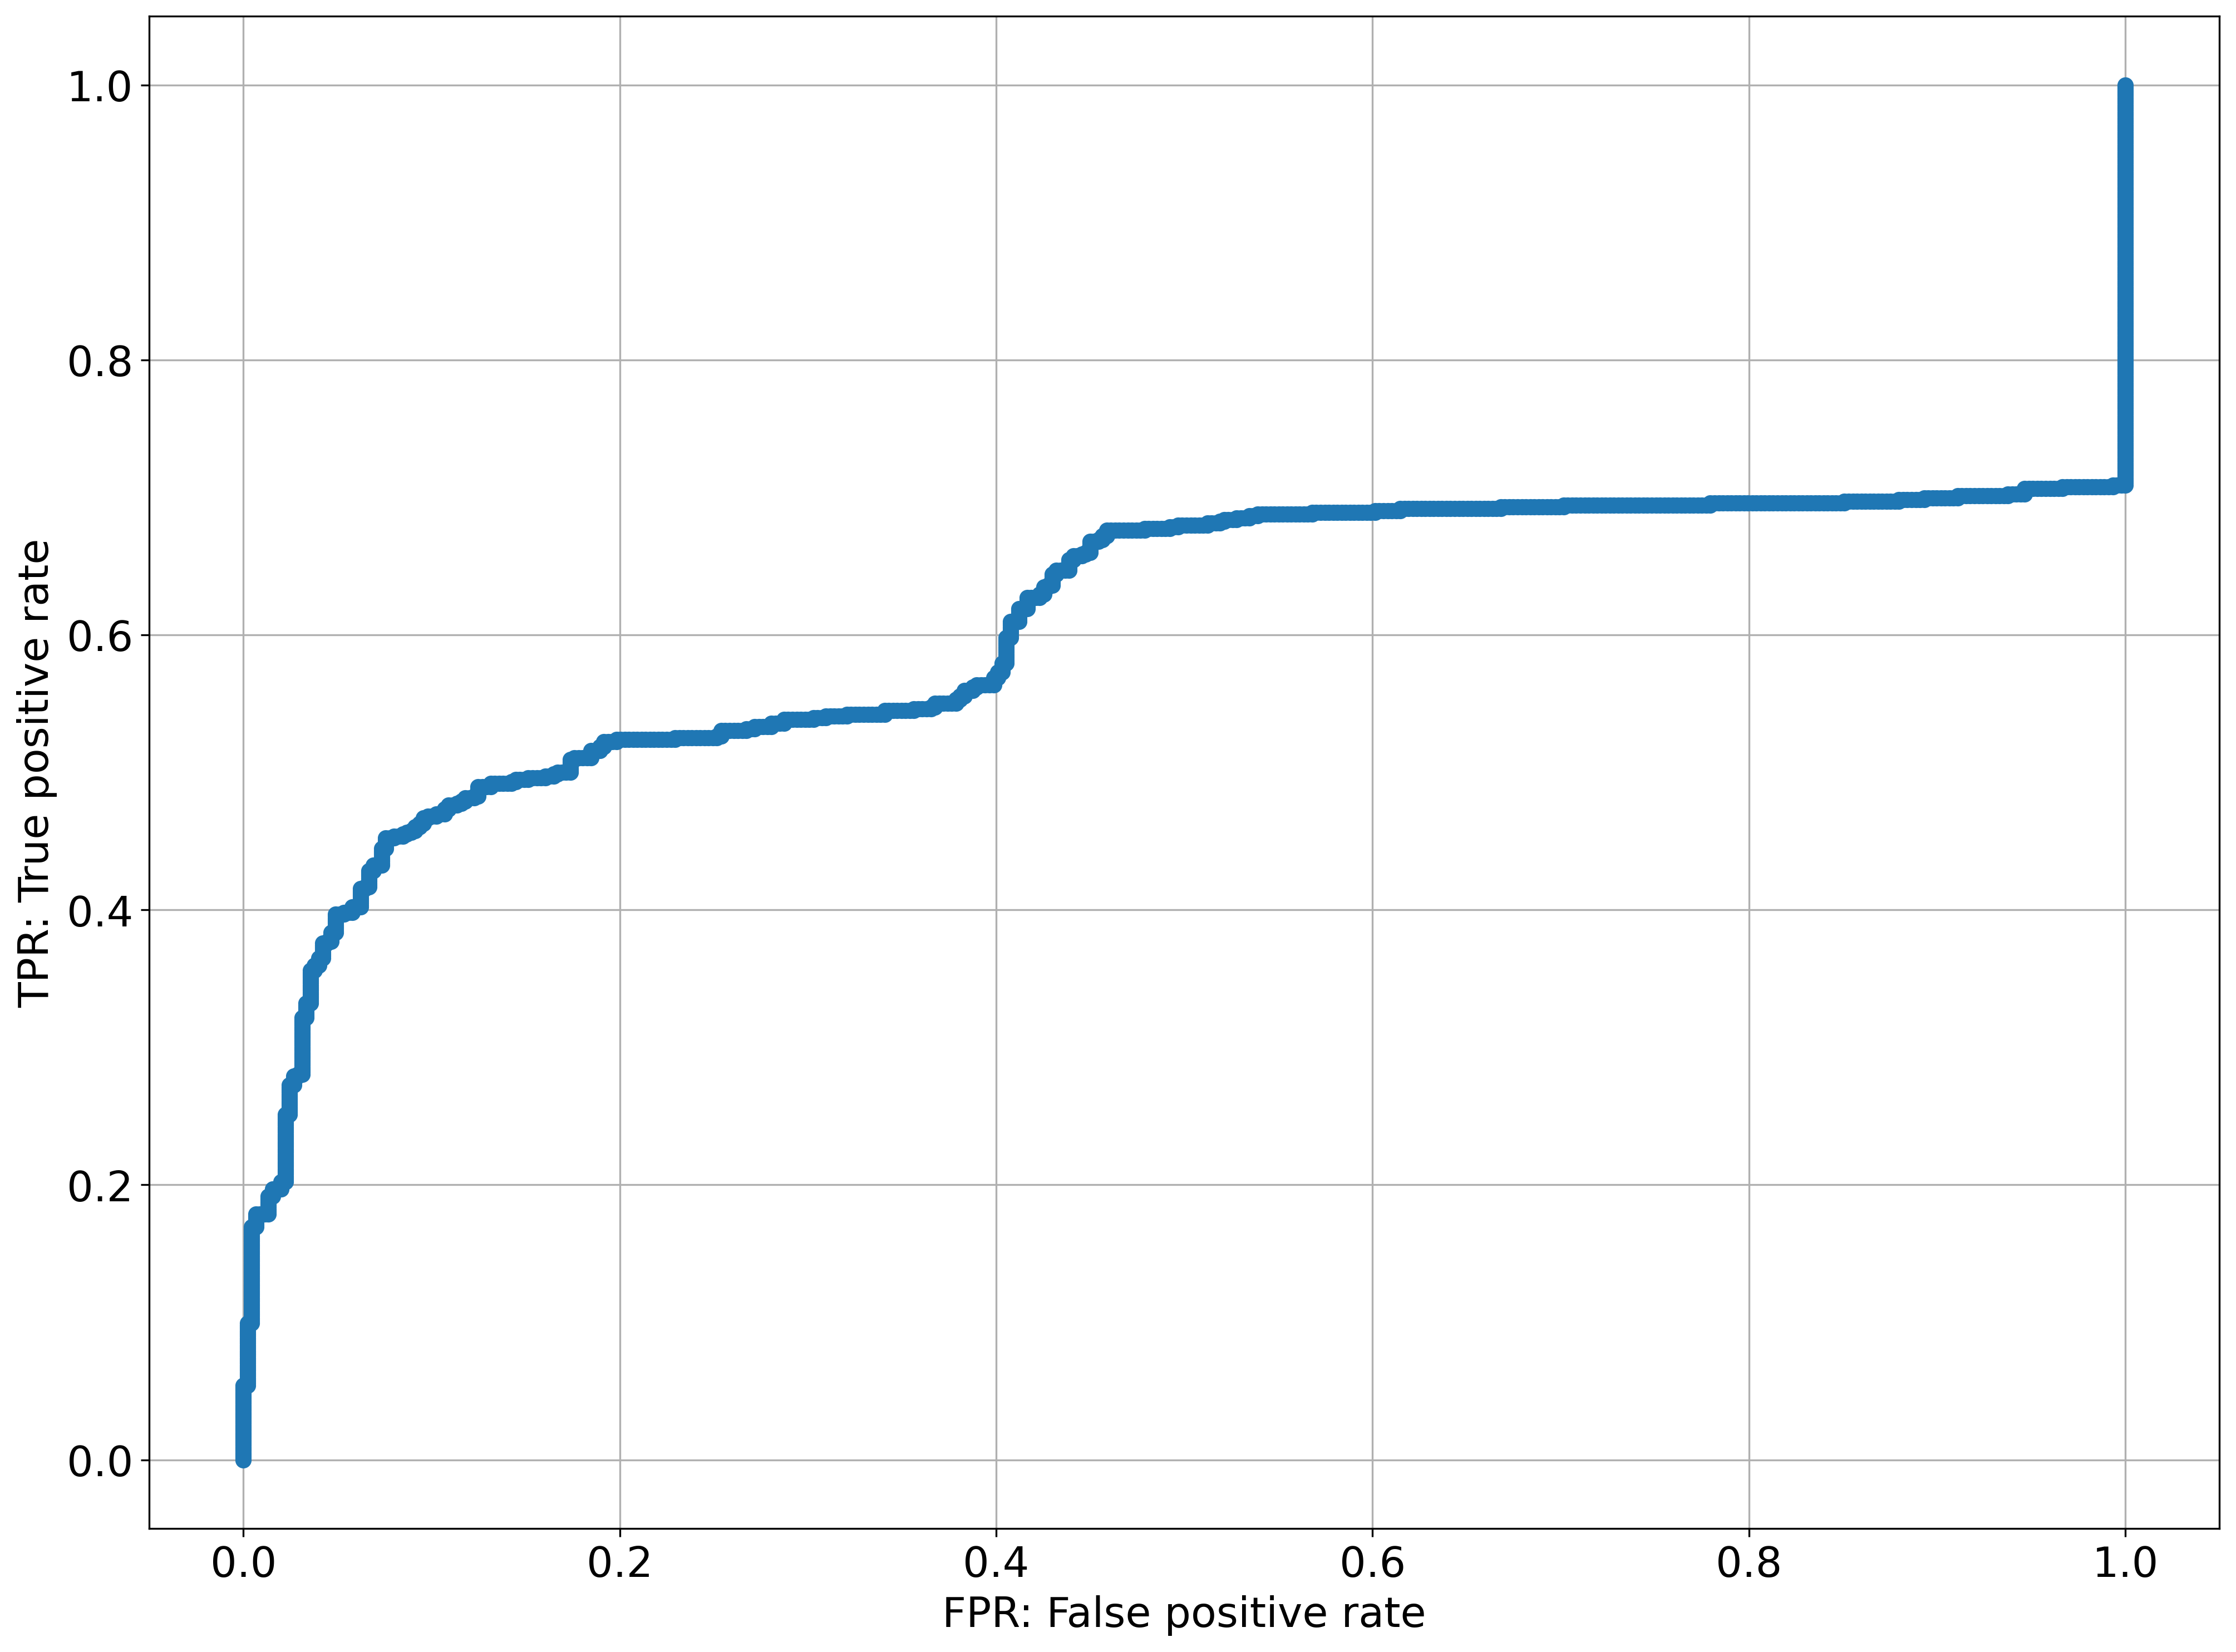

In [119]:
fpr_all, tpr_all, thresholds_all = roc_curve(y_true, y_score,
                                             drop_intermediate=False)

plt.figure(figsize=(16,12), dpi=300)
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.rcParams["font.size"] = 30
plt.grid()

In [113]:
print(roc_auc_score(y_true, y_score))

0.6045091384735037
